In this part we are going implement the idea proposed by the paper "Breast Cancer Histopathology Image Classification
and Localization using Multiple Instance Learning" and reproduce some of their results. Please read this paper before starting the next part. Here is the link to it:

https://arxiv.org/pdf/2003.00823.pdf

In the next sections, we only use one of the presented datasets in the above paper. In the explanation of every section, it is assumed that you have read the paper before starting that part. It should also be mentioned that you are free to modify everything in this notebook and all provided codes are for better understanding.

You can read the "Attention-based Deep Multiple Instance Learning" paper for more explanation. Here is the link to it:

https://arxiv.org/pdf/1802.04712.pdf

## Imports

Feel free to import any library you need.

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import os
import glob
from PIL import Image
import torch.nn.functional as F
import random
import torch.optim as optim

## Downloading dataset

Here is the code to download and decompress the BreaKHis dataset. This code is written for the google colab environment and you may need to modify it for running on other devices.

Link to the dataset's website:

https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

In [ ]:
!wget http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz -O /content/BreaKHis_v1.tar.gz

In [3]:
import shutil
from google.colab import drive
drive.mount('/content/drive')
shutil.copy('/content/BreaKHis_v1.tar.gz', '/content/drive/MyDrive/')

Mounted at /content/drive


'/content/drive/MyDrive/BreaKHis_v1.tar.gz'

In [4]:
!tar xzf /content/BreaKHis_v1.tar.gz -C /content

## Data Preparation (35 points)

In this section, you will implement several things:

- A custom pytorch Dataset for our data. You can use the current decompressed folder or change the structure to make it easier to work with.
- Transformations to perform on data (You must first do the patch extraction, then apply the transformations on every patch.)
- Patch extraction code (you can also implement it in the following sections)
- Dataloaders (instead of 80-20 split for train-test sets from the paper, you should use 80-5-15 split for train-val-test sets here and save best model w.r.t. the validation loss)

In [35]:
# Implement the custom dataset here (15 points)
class CustomBreaKHis(torch.utils.data.Dataset):
    def __init__(self, path_to_data, magn, transform=None):
        self.transform = transform
        self.root = path_to_data
        self.magn = magn
        self.raw_samples1 = glob.glob(self.root + '/benign/SOB/*/*/*/*')
        self.raw_samples2 = glob.glob(self.root + '/malignant/SOB/*/*/*/*')
        self.samples = []
        for raw_sample in self.raw_samples1:
          if raw_sample.split('/')[-2] == self.magn:
            self.samples.append((raw_sample, 0))
            #print(raw_sample,raw_sample.split('/')[-1])
        for raw_sample in self.raw_samples2:
          if raw_sample.split('/')[-2] == self.magn:
            self.samples.append((raw_sample, 1))
            #print(raw_sample,raw_sample.split('/')[-1])

        self.t = transforms.Compose([
            transforms.CenterCrop((448,700)),])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        image_dir, label = self.samples[index]

        array = []


        image = Image.open(image_dir)
        image = np.array(self.t(image))
        r, c, _ = image.shape
        for i in range(0,28*16,28):
            for j in range(0,28*25,28):
                array.append(self.transform(image[i:i+28, j:j+28, :]))
        array = tuple(array)
        array = torch.stack(array, 0)
        return array, label

In [29]:
# Implement the transforms here (5 points)
transform = transforms.Compose([

    transforms.ToTensor(),
])

In [36]:
# Create dataloaders here (5 points)
magnifications = ["40X", "100X", "200X", "400X"]

dataset40 = CustomBreaKHis("/content/BreaKHis_v1/histology_slides/breast", magnifications[0], transform)
dataset100 = CustomBreaKHis("/content/BreaKHis_v1/histology_slides/breast", magnifications[1], transform)
dataset200 = CustomBreaKHis("/content/BreaKHis_v1/histology_slides/breast", magnifications[2], transform)
dataset400 = CustomBreaKHis("/content/BreaKHis_v1/histology_slides/breast", magnifications[3], transform)
num_workers = 3
batch_size = 1
#  40X
dataset_size = len(dataset40)
train_size = int(0.8 * dataset_size)
val_size = int(0.05 * dataset_size)
train_dataset, test_dataset, val_dataset = random_split(dataset40, [train_size, dataset_size - train_size - val_size, val_size])
train_loader40 = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers ,shuffle=True)
val_loader40 = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers,shuffle=False)
test_loader40 = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,shuffle=False)

#  100X
dataset_size = len(dataset100)
train_size = int(0.8 * dataset_size)
val_size = int(0.05 * dataset_size)
train_dataset, test_dataset, val_dataset = random_split(dataset100, [train_size, dataset_size - train_size - val_size, val_size])
train_loader100 = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers,shuffle=True)
val_loader100 = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers,shuffle=False)
test_loader100 = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,shuffle=False)


#  200X
dataset_size = len(dataset200)
train_size = int(0.8 * dataset_size)
val_size = int(0.05 * dataset_size)
train_dataset, test_dataset, val_dataset = random_split(dataset200, [train_size, dataset_size - train_size - val_size, val_size])
train_loader200 = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers,shuffle=True)
val_loader200 = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers,shuffle=False)
test_loader200 = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,shuffle=False)

#  400X
dataset_size = len(dataset400)
train_size = int(0.8 * dataset_size)
val_size = int(0.05 * dataset_size)
train_dataset, test_dataset, val_dataset = random_split(dataset400, [train_size, dataset_size - train_size - val_size, val_size])
train_loader400 = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers,shuffle=True)
val_loader400 = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers,shuffle=False)
test_loader400 = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
# Implement patch extraction here (10 points)
# If you are going to implement it somewhere else, please comment it here.
# I managed this in the getitem of my dataset class

## Model Implementation (25 points)

Here, you have to implement the proposed architecture in the paper. The only point is that in the last part of the model, instead of a "dense+softmax" you should implement a "dense+sigmoid".

In [31]:
# Implement the model here (25 points)
class MIL(nn.Module):
    def __init__(self):
        super(MIL, self).__init__()
        self.L = 500
        self.D = 128
        self.K = 1

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(50 * 4 * 4, self.L),
            nn.ReLU(),
        )

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(0)
        H = self.feature_extractor_part1(x)
        H = H.view(-1, 50 * 4 * 4)
        H = self.feature_extractor_part2(H)

        A = self.attention(H)
        A = torch.transpose(A, 1, 0)
        A = F.softmax(A, dim=1)

        M = torch.mm(A, H)

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob, 0.5).float()

        return Y_prob, Y_hat, A

    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()

        return error, Y_hat

    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob)) 

        return neg_log_likelihood, A

## Training (32 points)

In this section, you will implement the training method and use it to train the model for every magnification. The model has to be trained for at least 60 epochs. But, in every epoch, we use 200 mini-batches to train the model instead of the whole training data, which means with a batch size of one, we use 200 images for training the model in every epoch. With this method, we spend less training time but actually, iterate whole data several times. (You have to make sure that the train loader will get shuffled correctly every epoch)

You should save loss and accuracy per epoch for training and validation sets. Then, you must plot the loss and accuracy of every magnification, which is crucial for scoring this assignment.

Hint: Training the model for one epoch takes around 7 seconds on the Google Colab environment. You have to train every model for at least 60 epochs, but longer training time can result in higher accuracies.

Note: You are not expected to achieve the exact accuracies reported in the paper for getting the full score. A correct implementation and sufficient training epochs receive the total score for this assignment.

In [47]:
from itertools import islice
# Implement the training method here (20 points)
max_steps = 200
def train(model, epoch, train_loader):
  model.train()
  train_loss = 0.
  train_error = 0.
  correct_label_pred = 0
  number = 0

  for batch_idx, (data, label) in enumerate(train_loader):
      number += 1
      bag_label = label[0]
      data, bag_label = data.cuda(), bag_label.cuda()
      #data, bag_label = Variable(data), Variable(bag_label)
      data = data.squeeze(0)

      optimizer.zero_grad()
      # calculate loss and metrics
      loss, _ = model.calculate_objective(data, bag_label)
      train_loss += loss.data[0]
      error, predicted_label_train = model.calculate_classification_error(data, bag_label)
      correct_label_pred += (int(bag_label) == int(predicted_label_train))
      train_error += error
      # backward pass
      loss.backward()
      # step
      optimizer.step()
      if number == 200:
        break

  # calculate loss and error for epoch
  train_loss /= len(train_loader)
  train_error /= len(train_loader)
  train_acc = (1 - train_error)*100

  print('Epoch: {}, Loss: {:.4f}, Train error: {:.4f}, Train accuracy: {:.2f}'.format(epoch, train_loss.cpu().numpy()[0], train_error, train_acc))
  return train_loss.cpu().numpy()[0], train_acc

def test(model, epoch, test_loader):
    model.eval()
    test_loss = 0.
    test_error = 0.
    for batch_idx, (data, label) in enumerate(test_loader):
        bag_label = label[0]
        data, bag_label = data.cuda(), bag_label.cuda()
        #data, bag_label = Variable(data), Variable(bag_label)
        loss, attention_weights = model.calculate_objective(data, bag_label)
        test_loss += loss.data[0]
        error, predicted_label = model.calculate_classification_error(data, bag_label)
        test_error += error

    test_error /= len(test_loader)
    test_loss /= len(test_loader)
    test_acc = (1 - test_error)*100

    print('Epoch: {}, Loss: {:.4f}, Val error: {:.4f}, Val accuracy: {:.2f}'.format(epoch, test_loss.cpu().numpy()[0], test_error, test_acc))
    return test_loss.cpu().numpy()[0], test_acc


In [48]:
# Train the model on the 40X data here (1 points)
epochs = 60
magn = "40X"
val_acc40 = []
val_loss40 = []
train_acc40 = []
train_loss40 = []
model40 = MIL().to("cuda")
optimizer = optim.Adam(model40.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=10e-5)

dataset_size = len(dataset40)
train_size = int(0.8 * dataset_size)
val_size = int(0.05 * dataset_size)
train_dataset, test_dataset, val_dataset = random_split(dataset40, [train_size, dataset_size - train_size - val_size, val_size])

for epoch in range(1, epochs + 1):
        print('----------Start Training----------')
        train_loader40 = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        train_result = train(model40, epoch, train_loader40)
        train_acc40.append(train_result[1])
        train_loss40.append(train_result[0])
        print('----------Start Validation----------')
        val_result = test(model40, epoch, val_loader40)
        val_acc40.append(val_result[1])
        val_loss40.append(val_result[0])

----------Start Training----------
Epoch: 1, Loss: 0.0802, Train error: 0.0401, Train accuracy: 95.99
----------Start Validation----------
Epoch: 1, Loss: 0.5829, Val error: 0.2727, Val accuracy: 72.73
----------Start Training----------
Epoch: 2, Loss: 0.0788, Train error: 0.0401, Train accuracy: 95.99
----------Start Validation----------
Epoch: 2, Loss: 0.5775, Val error: 0.2727, Val accuracy: 72.73
----------Start Training----------
Epoch: 3, Loss: 0.0767, Train error: 0.0388, Train accuracy: 96.12
----------Start Validation----------
Epoch: 3, Loss: 0.5656, Val error: 0.2727, Val accuracy: 72.73
----------Start Training----------
Epoch: 4, Loss: 0.0745, Train error: 0.0420, Train accuracy: 95.80
----------Start Validation----------
Epoch: 4, Loss: 0.5514, Val error: 0.2424, Val accuracy: 75.76
----------Start Training----------
Epoch: 5, Loss: 0.0749, Train error: 0.0351, Train accuracy: 96.49
----------Start Validation----------
Epoch: 5, Loss: 0.5418, Val error: 0.2020, Val accura

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a0af31b880>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a0af31b880>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x78a0af31b880>    self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.

Epoch: 16, Loss: 0.5071, Val error: 0.2020, Val accuracy: 79.80
----------Start Training----------
Epoch: 17, Loss: 0.0634, Train error: 0.0269, Train accuracy: 97.31
----------Start Validation----------
Epoch: 17, Loss: 0.4994, Val error: 0.2121, Val accuracy: 78.79
----------Start Training----------
Epoch: 18, Loss: 0.0572, Train error: 0.0201, Train accuracy: 97.99
----------Start Validation----------
Epoch: 18, Loss: 0.5862, Val error: 0.2727, Val accuracy: 72.73
----------Start Training----------
Epoch: 19, Loss: 0.0635, Train error: 0.0301, Train accuracy: 96.99
----------Start Validation----------
Epoch: 19, Loss: 0.5202, Val error: 0.2222, Val accuracy: 77.78
----------Start Training----------
Epoch: 20, Loss: 0.0598, Train error: 0.0244, Train accuracy: 97.56
----------Start Validation----------
Epoch: 20, Loss: 0.5087, Val error: 0.2020, Val accuracy: 79.80
----------Start Training----------
Epoch: 21, Loss: 0.0621, Train error: 0.0269, Train accuracy: 97.31
----------Start V

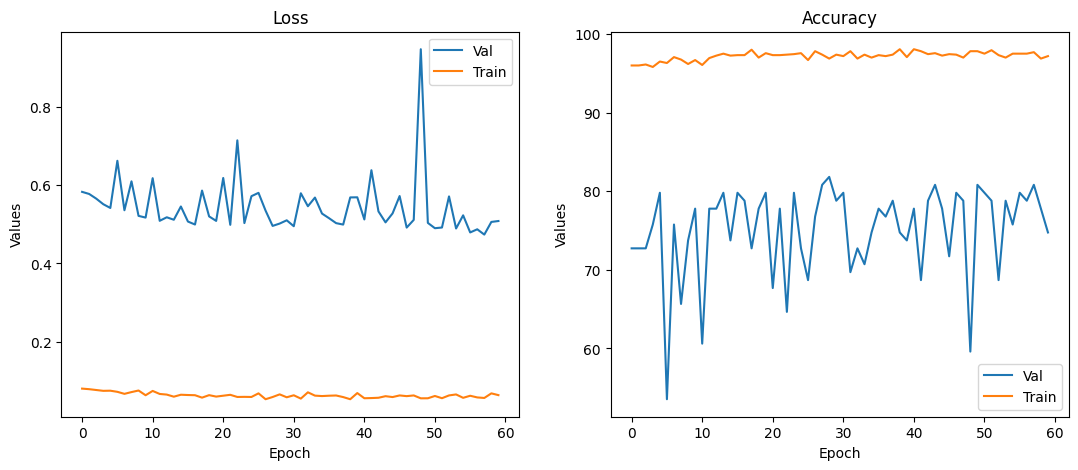

In [49]:
import matplotlib.pyplot as plt

# Plot loss and accuracy per epoch for 40X here (2 points)
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(val_loss40, label='Val')
plt.plot(train_loss40, label='Train')

plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Loss')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc40, label='Val')
plt.plot(train_acc40, label='Train')

plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Accuracy')

plt.legend()
plt.show()

In [50]:
# Train the model on the 100X data here (1 points)
epochs = 60
magn = "100X"
val_acc100 = []
val_loss100 = []
train_acc100 = []
train_loss100 = []
model100 = MIL().to("cuda")
optimizer = optim.Adam(model100.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=10e-5)

dataset_size = len(dataset100)
train_size = int(0.8 * dataset_size)
val_size = int(0.05 * dataset_size)
train_dataset, test_dataset, val_dataset = random_split(dataset100, [train_size, dataset_size - train_size - val_size, val_size])

for epoch in range(1, epochs + 1):
        print('----------Start Training----------')
        train_loader100 = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        train_result = train(model100, epoch, train_loader100)
        train_acc100.append(train_result[1])
        train_loss100.append(train_result[0])
        print('----------Start Validation----------')
        val_result = test(model100, epoch, val_loader100)
        val_acc100.append(val_result[1])
        val_loss100.append(val_result[0])

----------Start Training----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1, Loss: 0.0794, Train error: 0.0421, Train accuracy: 95.79
----------Start Validation----------
Epoch: 1, Loss: 0.6575, Val error: 0.3942, Val accuracy: 60.58
----------Start Training----------
Epoch: 2, Loss: 0.0768, Train error: 0.0433, Train accuracy: 95.67
----------Start Validation----------
Epoch: 2, Loss: 0.6371, Val error: 0.3942, Val accuracy: 60.58
----------Start Training----------
Epoch: 3, Loss: 0.0709, Train error: 0.0385, Train accuracy: 96.15
----------Start Validation----------
Epoch: 3, Loss: 0.5845, Val error: 0.2692, Val accuracy: 73.08
----------Start Training----------
Epoch: 4, Loss: 0.0614, Train error: 0.0276, Train accuracy: 97.24
----------Start Validation----------
Epoch: 4, Loss: 0.5632, Val error: 0.2596, Val accuracy: 74.04
----------Start Training----------
Epoch: 5, Loss: 0.0608, Train error: 0.0312, Train accuracy: 96.88
----------Start Validation----------
Epoch: 5, Loss: 0.6484, Val error: 0.3750, Val accuracy: 62.50
----------Start Training-

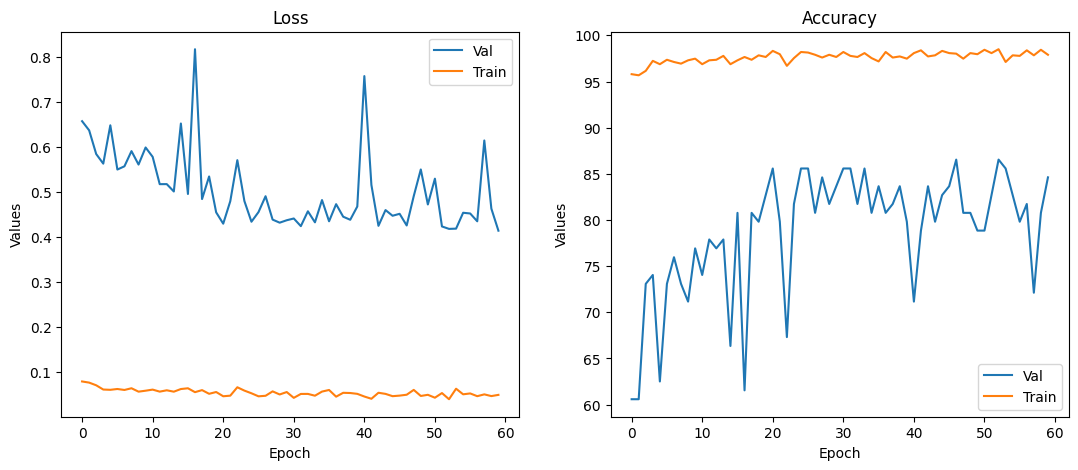

In [51]:
# Plot loss and accuracy per epoch for 100X here (2 points)

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(val_loss100, label='Val')
plt.plot(train_loss100, label='Train')
گ
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Loss')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc100, label='Val')
plt.plot(train_acc100, label='Train')

plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Accuracy')

plt.legend()
plt.show()

In [52]:
# Train the model on the 200X data here (1 points)
epochs = 60
magn = "200X"
val_acc200 = []
val_loss200 = []
train_acc200 = []
train_loss200 = []
model200 = MIL().to("cuda")
optimizer = optim.Adam(model200.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=10e-5)

dataset_size = len(dataset200)
train_size = int(0.8 * dataset_size)
val_size = int(0.05 * dataset_size)
train_dataset, test_dataset, val_dataset = random_split(dataset200, [train_size, dataset_size - train_size - val_size, val_size])

for epoch in range(1, epochs + 1):
        print('----------Start Training----------')
        train_loader200 = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        train_result = train(model200, epoch, train_loader100)
        train_acc200.append(train_result[1])
        train_loss200.append(train_result[0])
        print('----------Start Validation----------')
        val_result = test(model200, epoch, val_loader200)
        val_acc200.append(val_result[1])
        val_loss200.append(val_result[0])

----------Start Training----------
Epoch: 1, Loss: 0.0746, Train error: 0.0379, Train accuracy: 96.21
----------Start Validation----------
Epoch: 1, Loss: 0.5919, Val error: 0.3200, Val accuracy: 68.00
----------Start Training----------
Epoch: 2, Loss: 0.0725, Train error: 0.0409, Train accuracy: 95.91
----------Start Validation----------
Epoch: 2, Loss: 0.5731, Val error: 0.2500, Val accuracy: 75.00
----------Start Training----------
Epoch: 3, Loss: 0.0643, Train error: 0.0319, Train accuracy: 96.81
----------Start Validation----------
Epoch: 3, Loss: 0.4635, Val error: 0.1600, Val accuracy: 84.00
----------Start Training----------
Epoch: 4, Loss: 0.0624, Train error: 0.0343, Train accuracy: 96.57
----------Start Validation----------
Epoch: 4, Loss: 0.4859, Val error: 0.1400, Val accuracy: 86.00
----------Start Training----------
Epoch: 5, Loss: 0.0630, Train error: 0.0270, Train accuracy: 97.30
----------Start Validation----------
Epoch: 5, Loss: 0.5069, Val error: 0.2800, Val accura

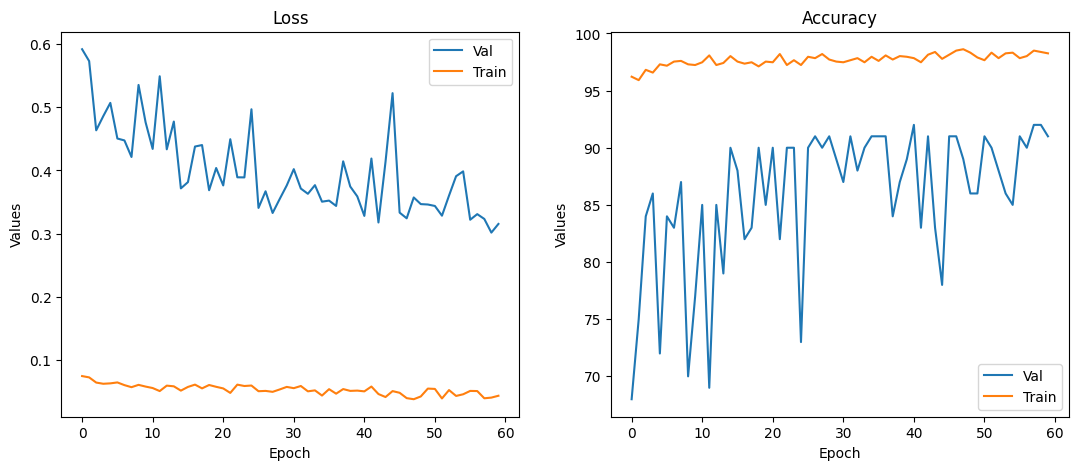

In [53]:
# Plot loss and accuracy per epoch for 200X here (2 points)
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(val_loss200, label='Val')
plt.plot(train_loss200, label='Train')

plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Loss')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc200, label='Val')
plt.plot(train_acc200, label='Train')

plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Accuracy')

plt.legend()
plt.show()

In [54]:
# Train the model on the 400X data here (1 points)
epochs = 60
magn = "400X"
val_acc400 = []
val_loss400 = []
train_acc400 = []
train_loss400 = []
model400 = MIL().to("cuda")
optimizer = optim.Adam(model400.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=10e-5)

dataset_size = len(dataset400)
train_size = int(0.8 * dataset_size)
val_size = int(0.05 * dataset_size)
train_dataset, test_dataset, val_dataset = random_split(dataset400, [train_size, dataset_size - train_size - val_size, val_size])

for epoch in range(1, epochs + 1):
        print('----------Start Training----------')
        train_loader400 = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        train_result = train(model400, epoch, train_loader400)
        train_acc400.append(train_result[1])
        train_loss400.append(train_result[0])
        print('----------Start Validation----------')
        val_result = test(model400, epoch, val_loader400)
        val_acc400.append(val_result[1])
        val_loss400.append(val_result[0])

----------Start Training----------
Epoch: 1, Loss: 0.0892, Train error: 0.0467, Train accuracy: 95.33
----------Start Validation----------
Epoch: 1, Loss: 0.5875, Val error: 0.2637, Val accuracy: 73.63
----------Start Training----------
Epoch: 2, Loss: 0.0820, Train error: 0.0426, Train accuracy: 95.74
----------Start Validation----------
Epoch: 2, Loss: 0.5446, Val error: 0.2637, Val accuracy: 73.63
----------Start Training----------
Epoch: 3, Loss: 0.0813, Train error: 0.0440, Train accuracy: 95.60
----------Start Validation----------
Epoch: 3, Loss: 0.4930, Val error: 0.2637, Val accuracy: 73.63
----------Start Training----------
Epoch: 4, Loss: 0.0728, Train error: 0.0364, Train accuracy: 96.36
----------Start Validation----------
Epoch: 4, Loss: 0.4744, Val error: 0.2418, Val accuracy: 75.82
----------Start Training----------
Epoch: 5, Loss: 0.0687, Train error: 0.0295, Train accuracy: 97.05
----------Start Validation----------
Epoch: 5, Loss: 0.4526, Val error: 0.2308, Val accura

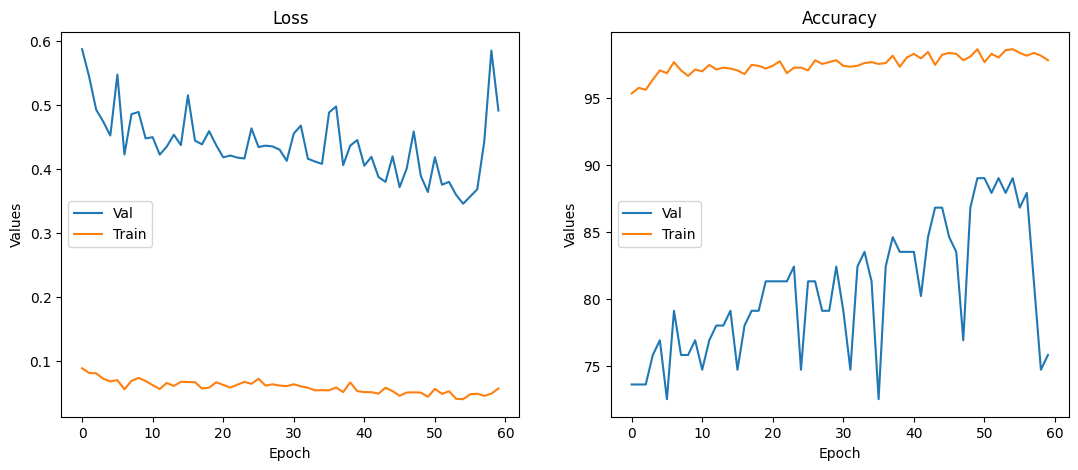

In [55]:
# Plot loss and accuracy per epoch for 400X here (2 points)
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(val_loss400, label='Val')
plt.plot(train_loss400, label='Train')

plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Loss')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc400, label='Val')
plt.plot(train_acc400, label='Train')

plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Accuracy')

plt.legend()
plt.show()

## Evaluation (8 points)

Now, we need to evaluate our best model in every magnification on the test set. Complete the test method and use it for the evaluation of models.

In [58]:
# Implement the test method here (4 points)
def test(model, test_loader):
    model.eval()
    test_loss = 0.
    test_error = 0.
    for batch_idx, (data, label) in enumerate(test_loader):
        bag_label = label[0]
        data, bag_label = data.cuda(), bag_label.cuda()
        #data, bag_label = Variable(data), Variable(bag_label)
        loss, attention_weights = model.calculate_objective(data, bag_label)
        test_loss += loss.data[0]
        error, predicted_label = model.calculate_classification_error(data, bag_label)
        test_error += error

    test_error /= len(test_loader)
    test_loss /= len(test_loader)
    test_acc = (1 - test_error)*100

    print('Loss: {:.4f}, Test error: {:.4f}, Test accuracy: {:.2f}'.format(test_loss.cpu().numpy()[0], test_error, test_acc))
    return

In [59]:
# Test the model trained on the 40X data here (1 points)
magn = "40X"
test(model40, test_loader40)

Loss: 0.5250, Test error: 0.2533, Test accuracy: 74.67


In [60]:
# Test the model trained on the 100X data here (1 points)
magn = "100X"
test(model100, test_loader100)

Loss: 0.3347, Test error: 0.1342, Test accuracy: 86.58


In [61]:
# Test the model trained on the 200X data here (1 points)
magn = "200X"
test(model200, test_loader200)

Loss: 0.3147, Test error: 0.1188, Test accuracy: 88.12


In [62]:
# Test the model trained on the 400X data here (1 points)
magn = "400X"
test(model400, test_loader400)

Loss: 0.4739, Test error: 0.2234, Test accuracy: 77.66
